# Simple Convolutional Neural Network

Using:
- 2 layers of convolution + ReLu + MaxPoolin
- 2 Fully connected layers

Library import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.framework import ops
session = tf.Session()
%config Completer.use_jedi = False

ops.reset_default_graph()
session = tf.Session()

Dataset import

In [4]:
data_dir = '../../Datasets/MNIST_data/'
mnist = input_data.read_data_sets(data_dir, one_hot = False)

Extracting ../../Datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../Datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../Datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../Datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


Training/test dataset split

In [5]:
train_xdata = np.array([np.reshape(x, (28,28)) for x in mnist.train.images])
test_xdata = np.array([np.reshape(x, (28,28)) for x in mnist.test.images])

train_labels = mnist.train.labels
test_labels = mnist.test.labels

Model parameters

In [36]:
batch_size = 50
learning_rate = 0.005
evaluation_size = 500
image_width = train_xdata[0].shape[0]
image_height = train_xdata[0].shape[1]
target_size = max(train_labels) + 1
num_channels = 1 #data colors -- B&W = 1 // RGB = 3
generations = 500
eval_every = 5
conv1_features = 25
conv2_features = 50
max_pool_size1 = 2   #Max pooling window size 2x2
max_pool_size2 = 2
full_connected_size1 = 100

Variables definition

In [37]:
x_input_shape = (batch_size, image_width, image_height, num_channels)
x_input = tf.placeholder(tf.float32, shape = x_input_shape)
y_target = tf.placeholder(tf.int32, shape = batch_size)

eval_input_shape = (evaluation_size, image_width, image_height, num_channels)
eval_input = tf.placeholder(tf.float32, shape = eval_input_shape)
eval_target = tf.placeholder(tf.float32, shape = evaluation_size)

Convolutional Operations

In [38]:
conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features], stddev = 0.1, dtype= tf.float32))
conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype = tf.float32))

conv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, conv2_features], stddev = 0.1, dtype= tf.float32))
conv2_bias = tf.Variable(tf.zeros([conv2_features], dtype = tf.float32))

Fully connected layers definition

In [39]:
resulting_width = image_width // (max_pool_size1 * max_pool_size2)  #Image result after convolution
result_height = image_height // (max_pool_size1 * max_pool_size2)

full1_input_size = resulting_width * result_height * conv2_features
full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, full_connected_size1], stddev= 0.1, dtype = tf.float32))
full1_bias = tf.Variable(tf.truncated_normal([full_connected_size1], stddev = 0.1, dtype = tf.float32))

full2_weight = tf.Variable(tf.truncated_normal([full_connected_size1, target_size], stddev = 0.1, dtype = tf.float32))
full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev = 0.1, dtype = tf.float32))

Neural network definition.

This function is responsable of apply all the operations related to CNN to the data feed into the training loop.

In [40]:
def my_conv_neural_net(input_data):
    #First layer == Conv + ReLu + MaxPool
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides = [1,1,1,1], padding = 'SAME')
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1, max_pool_size1, max_pool_size1, 1],
                               strides = [1, max_pool_size1, max_pool_size1, 1], padding = 'SAME')
    #Second layer == Conv + ReLu + MaxPool
    conv2 = tf.nn.conv2d(max_pool1, conv2_weight, strides = [1,1,1,1], padding = 'SAME')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1, max_pool_size2, max_pool_size2, 1],
                               strides = [1, max_pool_size2, max_pool_size2, 1], padding = 'SAME')    
    #Flattening == 1xN vector to Fully connected layer
    final_conv_shape = max_pool2.get_shape().as_list()
    final_shape = final_conv_shape[1] * final_conv_shape [2] * final_conv_shape [3]
    flat_output = tf.reshape(max_pool2, [final_conv_shape[0], final_shape])
    #Third layer == fully connected
    fully_connected_1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))
    #Fourth layer == fully connected
    fully_connected_2 = tf.add(tf.matmul(fully_connected_1, full2_weight), full2_bias)
    return fully_connected_2

In [41]:
model_output = my_conv_neural_net(x_input)
test_model_output = my_conv_neural_net(eval_input)

Loss function.

Using softmax regularization with logits. 

In [42]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = model_output, labels= y_target))

Prediction function. Using the probability of the model output then convert to a number and compare with the validation dataset. 

In [43]:
prediction = tf.nn.softmax(model_output)
test_prediction = tf.nn.softmax(test_model_output)

def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis = 1)
    num_corrects = np.sum(np.equal(batch_predictions, targets))
    return 100.0*num_corrects / batch_predictions.shape[0]

Train step using Momentum optimizer and loss function.

In [44]:
my_optim = tf.train.MomentumOptimizer(learning_rate = learning_rate, momentum = 0.9)
train_step = my_optim.minimize(loss)

Variable initialization

In [45]:
init = tf.global_variables_initializer()
session.run(init)

Training Loop

In [47]:
train_loss = []
train_acc = []
test_acc = []
i_vals = []

for i in range(generations):
    rand_idx = np.random.choice(len(train_xdata), size = batch_size)
    rand_x = train_xdata[rand_idx]
    rand_x = np.expand_dims(rand_x, 3)
    rand_y = train_labels[rand_idx]
    train_dict = {x_input: rand_x,
                  y_target: rand_y}
    session.run(train_step, feed_dict= train_dict)
    temp_train_loss, temp_train_preds = session.run([loss, prediction], feed_dict = train_dict)
    temp_train_acc = get_accuracy(temp_train_preds, rand_y)
    
    if (i+1) % eval_every == 0:
        rand_idx_eval = np.random.choice(len(test_xdata), size = evaluation_size)
        rand_x_eval = test_xdata[rand_idx_eval]
        rand_x_eval = np.expand_dims(rand_x_eval, 3)
        rand_y_eval = test_labels[rand_idx_eval]
        test_dict = {eval_input: rand_x_eval,
                      eval_target: rand_y_eval}
        temp_test_preds = session.run(test_prediction, feed_dict = test_dict)
        temp_test_acc = get_accuracy(temp_test_preds, rand_y_eval)
        
        train_loss.append(temp_train_loss)
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)
        
        acc_and_loss = [(i+1), temp_train_loss, temp_train_acc, temp_test_acc]
        acc_and_loss = [np.round(x,3) for x in acc_and_loss]
        print('Iteration #{}. Train Loss: {:.3f}. Train Accuracy: {:.3f}. Test Accuracy: {:.3f}'.format(*acc_and_loss))
        

Iteration #5. Train Loss: 2.111. Train Accuracy: 40.000. Test Accuracy: 27.400
Iteration #10. Train Loss: 2.132. Train Accuracy: 30.000. Test Accuracy: 36.000
Iteration #15. Train Loss: 1.922. Train Accuracy: 32.000. Test Accuracy: 50.000
Iteration #20. Train Loss: 1.573. Train Accuracy: 56.000. Test Accuracy: 56.000
Iteration #25. Train Loss: 1.421. Train Accuracy: 66.000. Test Accuracy: 64.400
Iteration #30. Train Loss: 1.123. Train Accuracy: 70.000. Test Accuracy: 67.600
Iteration #35. Train Loss: 0.932. Train Accuracy: 78.000. Test Accuracy: 72.400
Iteration #40. Train Loss: 0.746. Train Accuracy: 80.000. Test Accuracy: 75.800
Iteration #45. Train Loss: 0.702. Train Accuracy: 80.000. Test Accuracy: 83.000
Iteration #50. Train Loss: 0.748. Train Accuracy: 72.000. Test Accuracy: 81.200
Iteration #55. Train Loss: 0.391. Train Accuracy: 90.000. Test Accuracy: 86.200
Iteration #60. Train Loss: 0.439. Train Accuracy: 82.000. Test Accuracy: 87.200
Iteration #65. Train Loss: 0.341. Train A

Model Performance

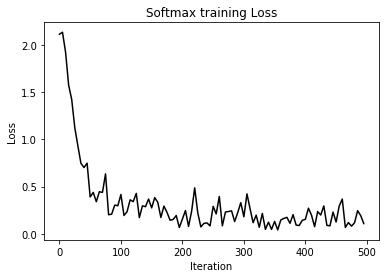

In [51]:
plt.plot(np.arange(0,500,5), train_loss, 'k-')
plt.title('Softmax training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()


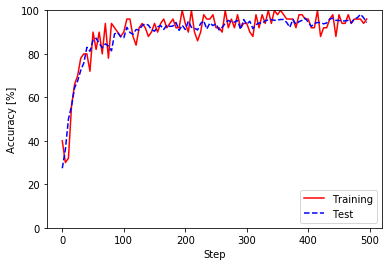

In [57]:
plt.plot(np.arange(0,500,5), train_acc, 'r-', label = 'Training')
plt.plot(np.arange(0,500,5), test_acc, 'b--', label = 'Test')
plt.xlabel('Step')
plt.ylabel('Accuracy [%]')
plt.ylim([0,100])
plt.legend(loc = 'lower right')
plt.show()

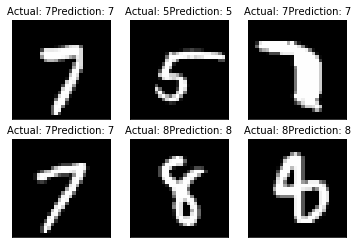

In [61]:
actuals = rand_y[0:6]
predictions = np.argmax(temp_train_preds, axis = 1)[0:6]
images = np.squeeze(rand_x[0:6])
nrow = 2
ncols = 3
for i in range(6):
    plt.subplot(nrow, ncols, i+1)
    plt.imshow(np.reshape(images[i], [28,28]), cmap = 'Greys_r')
    plt.title('Actual: '+str(actuals[i]) + 'Prediction: '+str(predictions[i]), fontsize = 10)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    